In [1]:
import pandas as pd
import numpy as np
import re
import os
import dask.dataframe as dd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn import tree
import graphviz
from openpyxl import load_workbook

In [2]:
periodo_movimento = input("INFORME O PERÍODO MOVIMENTO: ")

gravar_tabela_indicadores = 'SIM'

data_fechamento = pd.to_datetime(periodo_movimento) + pd.offsets.MonthEnd(1) # Data Fechamento (último dia do mês de fechamento)

# Extrai o ano
ano = str(periodo_movimento.split('-')[0])

# Base Crediário

In [3]:
df_crediario = pd.read_csv(fr'C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\Desenvolvimento\DF_CREDIARIO_2025-08.csv',sep=";")

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\2309968598.py:1: DtypeWarning: Columns (2,6,8,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df_crediario = pd.read_csv(fr'C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\Desenvolvimento\DF_CREDIARIO_2025-08.csv',sep=";")


# Base Behavior

In [7]:
# Tratando a base Behavior
#df_behavior_1 = pd.read_csv(r'C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\Teste - Sem filtro\relatorio_prob_inad_train.csv', sep=",") 
#df_behavior_2 = pd.read_csv(r'C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\Teste - Sem filtro\relatorio_prob_inad_test.csv', sep=",")
#df_behavior = pd.concat([df_behavior_1, df_behavior_2], axis=0)  # axis=0 → concatena por colunas

# Tratando a base Behavior
df_behavior = pd.read_csv(r'C:\Users\fernando.monteiro\deep-torch-example\KAB\Behavior_KAB\Teste - Sem filtro\relatorio_analitico_202508.csv', sep=";") 


# Tratando a base Behavior

In [8]:
# Ajustar coluna CPF/CNPJ
df_behavior['cpf_cnpj'] = (
    df_behavior['cpf_cnpj']
    .astype('Int64')             # trata floats e NaN, vira inteiro nulo quando precisar
    .astype(str)                 # converte para string
    .str.replace(r'\.0$', '', regex=True)  # remove final .0 se existir
    .str.zfill(11)               # completa com zeros à esquerda
)

# Garantir que o tipo seja objeto
df_behavior['cpf_cnpj'] = df_behavior['cpf_cnpj'].astype(object)


df_behavior['SCR'] = df_behavior['SCR'].round().astype(int)

In [9]:
import locale
locale.setlocale(locale.LC_ALL, 'pt_BR.UTF-8')

#df_behavior.to_excel("saida.xlsx", index=False, float_format="%.6f")


'pt_BR.UTF-8'

In [10]:
import pandas as pd

# Identifica as colunas que terminam com _shap
cols_shap = [c for c in df_behavior.columns if c.endswith('_shap')]

# Converte os valores para string formatada com vírgula
df_behavior[cols_shap] = df_behavior[cols_shap].applymap(
    lambda x: f"{x:.6f}".replace('.', ',') if pd.notnull(x) else ""
)

# Caminho para salvar
caminho = r"C:\Users\uilson.zamboni\Desktop\testes\df_behavior.xlsx"

# Salva no Excel
#df_behavior.to_excel(caminho, index=False)

print(f"Arquivo salvo em: {caminho}")


Arquivo salvo em: C:\Users\uilson.zamboni\Desktop\testes\df_behavior.xlsx


C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\1811291908.py:7: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_behavior[cols_shap] = df_behavior[cols_shap].applymap(


# Importando a base Kredilig (Contratos)

In [11]:
# Caminho das bases
bases_leitura = r'C:\Users\fernando.monteiro\Downloads\bases_contratos'
arquivos = [
    'IFM_OPERACOES.txt',
    'BASE_CARTOES.txt',
]

# Dicionário para armazenar os DataFrames
dataframes = {}

# Leitura dos arquivos com Dask
for arquivo in arquivos:
    caminho_arquivo = os.path.join(bases_leitura, arquivo)
    nome_dataframe = arquivo.split('.')[0]
    
    try:
        # Leitura usando Dask DataFrame, definindo dtype como object para evitar erros
        dataframes[nome_dataframe] = dd.read_csv(
            caminho_arquivo,
            delimiter=';',
            encoding='utf-8',
            assume_missing=True,
            dtype='object',  # Trata todas as colunas como string inicialmente
            low_memory=False  # Processa com mais memória para evitar warnings
        )
    
    except Exception as e:
        print(f"Erro ao ler o arquivo {arquivo}: {e}")
        continue

# DataFrames resultantes
df_contratos = dataframes.get('IFM_OPERACOES')
df_cartoes = dataframes.get('BASE_CARTOES')


if df_contratos is not None:
    print("IFM_OPERACOES carregada com sucesso.")

if df_cartoes is not None:
    print("BASE_CARTOES carregada com sucesso.")

# Computando sem filtros
df_contratos = df_contratos.compute()
df_cartoes = df_cartoes.compute()

IFM_OPERACOES carregada com sucesso.
BASE_CARTOES carregada com sucesso.


In [12]:
# Atribuindo o df_contratos em uma variável
df_contratos_ajustado = df_contratos.copy()

# Listas das colunas a serem convertidas
colunas_para_converter_float = [
'IFMOPERACOES_VLRSLDCONTABIL'             ,
'IFMOPERACOES_VLRSLDRENDA'                ,
'IFMOPERACOES_VLRSLDCURVA'                ,
'IFMOPERACOES_VLRCONTABILBRUTO'           ,
'IFMOPERACOES_VLRTAXAANUAL'               ,
'IFMOPERACOES_VLRPROVISAOPISOBC'          ,
'IFMOPERACOES_VLRLIMCREDVENCATE360'       ,
'IFMOPERACOES_VLRLIMCREDVENCACIMA360'     ,
'IFMOPERACOES_VLRCREDLIBERARATE360'       ,
'IFMOPERACOES_VLRCREDLIBERARACIMA360'     ,
'IFMOPERACOES_VLRCREDAVENCERATE30'        ,
'IFMOPERACOES_VLRCREDAVENCER31_60'        ,
'IFMOPERACOES_VLRCREDAVENCER61_90'        ,
'IFMOPERACOES_VLRCREDAVENCER91_180'       ,
'IFMOPERACOES_VLRCREDAVENCER181_360'      ,
'IFMOPERACOES_VLRCREDAVENCER361_720'      ,
'IFMOPERACOES_VLRCREDAVENCER721_1080'     ,
'IFMOPERACOES_VLRCREDAVENCER1081_1440'    ,
'IFMOPERACOES_VLRCREDAVENCER1441_1800'    ,
'IFMOPERACOES_VLRCREDAVENCER1801_5400'    ,
'IFMOPERACOES_VLRCREDAVENCERACIMA5400'    ,
'IFMOPERACOES_VLRCREDAVENCERINDETERMINADO',
'IFMOPERACOES_VLRCREDAVENCERTOTAL'        ,
'IFMOPERACOES_VLRCREDVENCIDO1_14'         ,
'IFMOPERACOES_VLRCREDVENCIDO15_30'        ,
'IFMOPERACOES_VLRCREDVENCIDO31_60'        ,
'IFMOPERACOES_VLRCREDVENCIDO61_90'        ,
'IFMOPERACOES_VLRCREDVENCIDO91_120'       ,
'IFMOPERACOES_VLRCREDVENCIDO121_150'      ,
'IFMOPERACOES_VLRCREDVENCIDO151_180'      ,
'IFMOPERACOES_VLRCREDVENCIDO181_240'      , 
'IFMOPERACOES_VLRCREDVENCIDO241_300'      ,
'IFMOPERACOES_VLRCREDVENCIDO301_360'      ,
'IFMOPERACOES_VLRCREDVENCIDO361_540'      ,
'IFMOPERACOES_VLRCREDVENCIDOACIMA540'     ,
'IFMOPERACOES_VLRCREDVENCIDOTOTAL'        ,
'IFMOPERACOES_VLRCREDPREJUIZOATE12M'      ,
'IFMOPERACOES_VLRCREDPREJUIZO12_48M'      ,
'IFMOPERACOES_VLRCREDPREJUIZOACIMA48M'    ,
'IFMOPERACOES_VLRCREDPREJUIZOTOTAL'       ,
'IFMOPERACOES_VLRFATURAMENTOANUAL'        ,
'IFMOPERACOES_VLRCONTRATADO'

]

colunas_para_converter_int = [
'IFMOPERACOES_IDNATOPERACAO'             ,
'IFMOPERACOES_IDTPPESSOA'                ,
'IFMOPERACOES_IDPERIODOATRASO'           ,
'IFMOPERACOES_IDTXREFERENCIAINDEXADOR'   ,
'IFMOPERACOES_IDPORTECLIENTE'            ,
'IFMOPERACOES_QTDEPARCELAS'              ,
'IFMOPERACOES_DIASATRASO'

]

colunas_para_converter_data = [
'IFMOPERACOES_DTMOVIMENTO'              , 
'IFMOPERACOES_DTVENCIMENTOATRASO'       ,
'IFMOPERACOES_DTVENCIMENTO'

]

# Função para converter valores numéricos corretamente
def converter_para_numero(valor):
    if isinstance(valor, str):
        if valor.strip() in ["-", ""]:
            return np.nan
        try:
            num = float(valor.replace("R$", "").replace(".", "").replace(",", ".").strip())
            if num > 1e7 or num < -1e7:  
                return np.nan
            return num
        except ValueError:
            return np.nan
    return valor  

# Verificar se o DataFrame é Pandas ou Dask
if isinstance(df_contratos_ajustado, pd.DataFrame):  
    # Converter colunas para float
    for coluna in colunas_para_converter_float:
        if coluna in df_contratos_ajustado.columns:
            df_contratos_ajustado[coluna] = pd.to_numeric(df_contratos_ajustado[coluna].apply(converter_para_numero),errors='coerce')
#df_contratos_ajustado[coluna].apply(converter_para_numero).astype(float)

    # Converter colunas para int
    for coluna in colunas_para_converter_int:
        if coluna in df_contratos_ajustado.columns:
            df_contratos_ajustado[coluna] = (
                df_contratos_ajustado[coluna]
                .apply(converter_para_numero)
                .fillna(0)
                .astype(int)
            )

    # Converter colunas para data
    for coluna in colunas_para_converter_data:
        if coluna in df_contratos_ajustado.columns:
            df_contratos_ajustado[coluna] = pd.to_datetime(df_contratos_ajustado[coluna], errors='coerce',  dayfirst=True)

else:
    # Se for um DataFrame Dask, usar map_partitions corretamente
    def processar_particao(df):
        for coluna in colunas_para_converter_float:
            if coluna in df.columns:
                df[coluna] = df[coluna].apply(converter_para_numero).astype(float)

        for coluna in colunas_para_converter_int:
            if coluna in df.columns:
                df[coluna] = df[coluna].apply(converter_para_numero).fillna(0).astype(int)

        for coluna in colunas_para_converter_data:
            if coluna in df.columns:
                df[coluna] = dd.to_datetime(df[coluna], errors='coerce', format='%d/%m/%Y')

        return df

    # Aplicar processamento por partições no Dask DataFrame
    df_contratos_ajustado = df_contratos_ajustado.map_partitions(processar_particao, meta=df_contratos_ajustado._meta)

#---------------------------------------------------------------------------------------------------#

# Converter para datetime para evitar erros
df_contratos_ajustado['ANO_MES_MOVIMENTO'] = df_contratos_ajustado['IFMOPERACOES_DTMOVIMENTO'].dt.strftime('%Y-%m')

#---------------------------------------------------------------------------------------------------#

df_contratos_filtrado = df_contratos_ajustado[
    (df_contratos_ajustado['ANO_MES_MOVIMENTO'] == periodo_movimento) #&
    #(df_contratos_ajustado['IFMOPERACOES_IDPREJUIZO'] == 'N')
]


C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\3882878813.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\3882878813.py:97: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  .fillna(0)


# Renomeando Colunas

In [13]:
# Dicionário de renomeação
rename_dict = {
    'IFMOPERACOES_CODDOCUMENTOCLIENTE'	      : 'CPF_CNPJ',
    'IFMOPERACOES_CODOPERACAO'	              : 'CONTRATO',
    'IFMOPERACOES_CODDIRECIONAMENTO'	      : 'DIRECIONAMENTO',
    'IFMOPERACOES_CODPRODUTO'	              : 'CODIGO_PRODUTO',
    'IFMOPERACOES_DSCPRODUTO'	              : 'DESCRICAO_PRODUTO',
    'IFMOPERACOES_IDMODALIDADE'	              : 'MODALIDADE',
    'IFMOPERACOES_VLRSLDCONTABIL'             : 'SALDO_CONTABIL',
    'IFMOPERACOES_VLRSLDRENDA'                : 'SALDO_RENDA',
    'IFMOPERACOES_VLRSLDCURVA'                : 'SALDO_CURVA',
    'IFMOPERACOES_VLRCONTABILBRUTO'           : 'SALDO_CONTABIL_BRUTO',
    'IFMOPERACOES_VLRTAXAANUAL'               : 'TAXA_ANUAL',
    'IFMOPERACOES_VLRPROVISAOPISOBC'          : 'VALOR_PROVISAO_PISO',
    'IFMOPERACOES_VLRLIMCREDVENCATE360'       : 'CREDITO_A_VENCE_ATE_360',
    'IFMOPERACOES_VLRLIMCREDVENCACIMA360'     : 'CREDITO_A_VENCER_ACIMA_360',
    'IFMOPERACOES_VLRCREDLIBERARATE360'       : 'CREDITO_A_LIBERAR_ATE_360',
    'IFMOPERACOES_VLRCREDLIBERARACIMA360'     : 'CREDITO_A_LIBERAR_ACIMA_360',
    'IFMOPERACOES_VLRCREDAVENCERATE30'        : 'CREDITO_A_VENCER_ATE_30',
    'IFMOPERACOES_VLRCREDAVENCER31_60'        : 'CREDITO_A_VENCER_31_60',
    'IFMOPERACOES_VLRCREDAVENCER61_90'        : 'CREDITO_A_VENCER_61_90',
    'IFMOPERACOES_VLRCREDAVENCER91_180'       : 'CREDITO_A_VENCER_91_180',
    'IFMOPERACOES_VLRCREDAVENCER181_360'      : 'CREDITO_A_VENCER_181_360',
    'IFMOPERACOES_VLRCREDAVENCER361_720'      : 'CREDITO_A_VENCER_361_720',
    'IFMOPERACOES_VLRCREDAVENCER721_1080'     : 'CREDITO_A_VENCER_721_1080',
    'IFMOPERACOES_VLRCREDAVENCER1081_1440'    : 'CREDITO_A_VENCER_1081_1440',
    'IFMOPERACOES_VLRCREDAVENCER1441_1800'    : 'CREDITO_A_VENCER_1441_1800',
    'IFMOPERACOES_VLRCREDAVENCER1801_5400'    : 'CREDITO_A_VENCER_1801_5400',
    'IFMOPERACOES_VLRCREDAVENCERACIMA5400'    : 'CREDITO_A_VENCER_ACIMA_5400',
    'IFMOPERACOES_VLRCREDAVENCERINDETERMINADO': 'CREDITO_A_VENCER_PRAZO_INDETERMINADO',
    'IFMOPERACOES_VLRCREDAVENCERTOTAL'        : 'CREDITO_A_VENCER_TOTAL',
    'IFMOPERACOES_VLRCREDVENCIDO1_14'         : 'CREDITO_VENCIDO_1_A_14',
    'IFMOPERACOES_VLRCREDVENCIDO15_30'        : 'CREDITO_VENCIDO_15_A_30',
    'IFMOPERACOES_VLRCREDVENCIDO31_60'        : 'CREDITO_VENCIDO_31_A_60',
    'IFMOPERACOES_VLRCREDVENCIDO61_90'        : 'CREDITO_VENCIDO_61_A_90',
    'IFMOPERACOES_VLRCREDVENCIDO91_120'       : 'CREDITO_VENCIDO_91_A_120',
    'IFMOPERACOES_VLRCREDVENCIDO121_150'      : 'CREDITO_VENCIDO_121_A_150',
    'IFMOPERACOES_VLRCREDVENCIDO151_180'      : 'CREDITO_VENCIDO_151_A_180',
    'IFMOPERACOES_VLRCREDVENCIDO181_240'      : 'CREDITO_VENCIDO_181_A_240',
    'IFMOPERACOES_VLRCREDVENCIDO241_300'      : 'CREDITO_VENCIDO_241_A_300',
    'IFMOPERACOES_VLRCREDVENCIDO301_360'      : 'CREDITO_VENCIDO_301_A_360',
    'IFMOPERACOES_VLRCREDVENCIDO361_540'      : 'CREDITO_VENCIDO_361_A_540',
    'IFMOPERACOES_VLRCREDVENCIDOACIMA540'     : 'CREDITO_VENCIDO_ACIMA_540',
    'IFMOPERACOES_VLRCREDVENCIDOTOTAL'        : 'CREDITO_VENCIDO_TOTAL',
    'IFMOPERACOES_VLRCREDPREJUIZOATE12M'      : 'CREDITO_PREJUIZO_ATE_12_M',
    'IFMOPERACOES_VLRCREDPREJUIZO12_48M'      : 'CREDITO_PREJUIZO_12_48_M',
    'IFMOPERACOES_VLRCREDPREJUIZOACIMA48M'    : 'CREDITO_PREJUIZO_ACIMA_48_M',
    'IFMOPERACOES_VLRCREDPREJUIZOTOTAL'       : 'CREDITO_PREJUIZO_TOTAL',
    'IFMOPERACOES_VLRFATURAMENTOANUAL'        : 'FATURAMENTO_ANUAL',
    'IFMOPERACOES_VLRCONTRATADO'              : 'VALOR_CONTRATO',
    'IFMOPERACOES_IDNATOPERACAO'              : 'ID_OPERACAO',
    'IFMOPERACOES_IDTPPESSOA'                 : 'ID_PESSOA',
    'IFMOPERACOES_IDPERIODOATRASO'            : 'ID_PERIORO_ATRASO',
    'IFMOPERACOES_IDTXREFERENCIAINDEXADOR'    : 'TAXA_INDEXADOR',
    'IFMOPERACOES_IDPORTECLIENTE'             : 'ID_PORTE_CLIENTE',
    'IFMOPERACOES_QTDEPARCELAS'               : 'QTD_PARCELAS',
    'IFMOPERACOES_DIASATRASO'                 : 'DIAS_ATRASO',
    'IFMOPERACOES_DTMOVIMENTO'                : 'DATA_MOVIMENTO',
    'IFMOPERACOES_DTVENCIMENTOATRASO'         : 'DATA_VENCIMENTO_ATRASO',
    'IFMOPERACOES_DTVENCIMENTO'               : 'DATA_VENCIMENTO',
    'IFMOPERACOES_IDPREJUIZO'	              : 'ID_PREJUIZO',
    'IFMOPERACOES_VLRPERDAINCORRIDABC'	      : 'PERDA_INCORRIDA',
    'IFMOPERACOES_VLRPROVISAOADICBC'	      : 'PROVISAO_ADIMPLENTE',
    'IFMOPERACOES_VLRPROVISAOPE'	          : 'PROVISAO_PE',
    'IFMOPERACOES_PERCPERDAINCORRIDABC'	      : 'PERCENTUAL_PERDA_INCORRIDA',
    'IFMOPERACOES_PERCPROVISAOADICBC'	      : 'PERCENTUAL_PROVISAO_ADIMPLENTE',
    'IFMOPERACOES_PERCPROVISAOPE'	          : 'PERCENTUAL_PROVISAO_PE',
    'IFMOPERACOES_VLRPROVISAOCALC'	          : 'VALOR_PROVISAO_CALCULADA',
    'IFMOPERACOES_IDMULTIPLICADOR'	          : 'ID_MULTIPLICADOR',
    'IFMOPERACOES_CODCARACTESPECIAL'	      : 'CARACTERISTICA_ESPECIAL',
    'IFMOPERACOES_CODPOLITICARISCO'	          : 'COD_POLITICA_RISCO',
    'IFMOPERACOES_DTEMISSAO'	              : 'DATA_EMISSAO',
    'IFMOPERACOES_CODAGENCIA'	              : 'COD_AGENCIA',
    'IFMOPERACOES_IDATIVOPROBLISOLADO'	      : 'ID_ATIVO_PROBLEMATICO',
    'IFMOPERACOES_CODPERIODOISOLADO'	      : 'COD_PERIODO_ISOLADO',
    'IFMOPERACOES_VLRCONTABILLIQUIDO'	      : 'VALOR_CONTABIL_LIQUIDO',
}

# Renomeando as colunas
df_contratos_filtrado = df_contratos_filtrado.rename(columns=rename_dict)


# Coluna: SALDO_OVER_15

In [14]:
df_contratos_filtrado['SALDO_OVER_15'] = np.where(
    df_contratos_filtrado['DIAS_ATRASO'] > 15,
    df_contratos_filtrado['SALDO_CURVA'],
    0
)

# Coluna: SALDO_OVER_90

In [15]:
df_contratos_filtrado['SALDO_OVER_15'] = np.where(
    df_contratos_filtrado['DIAS_ATRASO'] > 15,
    df_contratos_filtrado['SALDO_CURVA'],
    0
)


df_crediario['SALDO_OVER_15_CURVA'] = np.where(
    df_crediario['DIAS_ATRASO'] > 15,
    df_crediario['SALDO_CURVA'],
    0
)

df_contratos_filtrado['SALDO_OVER_30'] = np.where(
    df_contratos_filtrado['DIAS_ATRASO'] > 30,
    df_contratos_filtrado['SALDO_CURVA'],
    0
)


df_crediario['SALDO_OVER_30_CURVA'] = np.where(
    df_crediario['DIAS_ATRASO'] > 30,
    df_crediario['SALDO_CURVA'],
    0
)

df_contratos_filtrado['SALDO_OVER_60'] = np.where(
    df_contratos_filtrado['DIAS_ATRASO'] > 60,
    df_contratos_filtrado['SALDO_CURVA'],
    0
)


df_crediario['SALDO_OVER_60_CURVA'] = np.where(
    df_crediario['DIAS_ATRASO'] > 60,
    df_crediario['SALDO_CURVA'],
    0
)

df_contratos_filtrado['SALDO_OVER_90'] = np.where(
    df_contratos_filtrado['DIAS_ATRASO'] > 90,
    df_contratos_filtrado['SALDO_CURVA'],
    0
)


df_crediario['SALDO_OVER_90_CURVA'] = np.where(
    df_crediario['DIAS_ATRASO'] > 90,
    df_crediario['SALDO_CURVA'],
    0
)

# Tratando coluna CPF_CNPJ ada base Behavior

In [16]:
# Converter para inteiro (removendo casas decimais) e depois para string
df_behavior['cpf_cnpj'] = (
    df_behavior['cpf_cnpj']
    .astype('int64')       # garante que vira inteiro
    .astype(str)           # transforma em string
    .str.zfill(11)         # completa com zeros à esquerda até 11 dígitos
)


In [17]:
# Converter para inteiro (removendo casas decimais) e depois para string
df_crediario = df_crediario.dropna(subset=['CPF_CNPJ'])
             
df_crediario['CPF_CNPJ'] = (
    df_crediario['CPF_CNPJ']
    .astype('int64')       # garante que vira inteiro
    .astype(str)           # transforma em string
    .str.zfill(11)         # completa com zeros à esquerda até 11 dígitos
)

In [18]:
import pandas as pd

# Copia para não alterar o original
df = df_contratos_filtrado.copy()

# Garantir tipos numéricos nas métricas (caso venham como string)
df['SALDO_CURVA'] = pd.to_numeric(df['SALDO_CURVA'], errors='coerce').fillna(0)
df['DIAS_ATRASO'] = pd.to_numeric(df['DIAS_ATRASO'], errors='coerce')

# 1) Base de CPFs únicos
df_base = df[['CPF_CNPJ']].drop_duplicates().reset_index(drop=True)

# 2) Somas condicionais por DIRECIONAMENTO
somas = (
    df.groupby(['CPF_CNPJ', 'DIRECIONAMENTO'])['SALDO_CURVA']
      .sum()
      .unstack('DIRECIONAMENTO')                # vira colunas FINA/EMPR/LIMI
      .reindex(columns=['FINA', 'EMPR', 'LIMI'], fill_value=0)  # garante as 3 colunas
      .rename(columns={
          'FINA': 'SALDO_CURVA_FINA',
          'EMPR': 'SALDO_CURVA_EMPR',
          'LIMI': 'SALDO_CURVA_LIMI'
      })
      .reset_index()
)

# 3) Maior DIAS_ATRASO por CPF (independente de modalidade)
dias_max = (
    df.groupby('CPF_CNPJ')['DIAS_ATRASO']
      .max()                     # sem skipna
      .rename('DIAS_ATRASO')
      .reset_index()
)

# 4) Monta o resultado final
df_resultado = (
    df_base
    .merge(somas, on='CPF_CNPJ', how='left')
    .merge(dias_max, on='CPF_CNPJ', how='left')
)

# Se quiser, substitui NaN de DIAS_ATRASO por 0 (opcional)
df_resultado['DIAS_ATRASO'] = df_resultado['DIAS_ATRASO'].fillna(0).astype(int)

# df_resultado é o novo DataFrame com:
# CPF_CNPJ, SALDO_CURVA_FINA, SALDO_CURVA_EMPR, SALDO_CURVA_LIMI, DIAS_ATRASO


In [19]:
df_crediario['MODALIDADE']

1         CREDIARIO
2         CREDIARIO
3         CREDIARIO
4         CREDIARIO
5         CREDIARIO
            ...    
309928    CREDIARIO
309929    CREDIARIO
309930    CREDIARIO
309931    CREDIARIO
309932    CREDIARIO
Name: MODALIDADE, Length: 309932, dtype: object

In [20]:
import pandas as pd

# Copia para não alterar o original
df = df_crediario.copy()

# Garantir tipos numéricos nas métricas (caso venham como string)
df['SALDO_CURVA'] = pd.to_numeric(df['SALDO_CURVA'], errors='coerce').fillna(0)
df['DIAS_ATRASO'] = pd.to_numeric(df['DIAS_ATRASO'], errors='coerce')

# 1) Base de CPFs únicos
df_base = df[['CPF_CNPJ']].drop_duplicates().reset_index(drop=True)

# 2) Somas condicionais por MODALIDADE
somas = (
    df.groupby(['CPF_CNPJ', 'MODALIDADE'])['SALDO_CURVA']
      .sum()
      .unstack('MODALIDADE')                # vira colunas FINA/EMPR/LIMI
      .reindex(columns=['CREDIARIO'], fill_value=0)  # garante as 3 colunas
      .rename(columns={
          'CREDIARIO': 'SALDO_CURVA_CREDIARIO',
      })
      .reset_index()
)

# 3) Maior DIAS_ATRASO por CPF (independente de modalidade)
dias_max = (
    df.groupby('CPF_CNPJ')['DIAS_ATRASO']
      .max()                     # sem skipna
      .rename('DIAS_ATRASO')
      .reset_index()
)

# 4) Monta o resultado final
df_resultado_cred = (
    df_base
    .merge(somas, on='CPF_CNPJ', how='left')
    .merge(dias_max, on='CPF_CNPJ', how='left')
)

# Se quiser, substitui NaN de DIAS_ATRASO por 0 (opcional)
df_resultado_cred['DIAS_ATRASO'] = df_resultado_cred['DIAS_ATRASO'].fillna(0).astype(int)

# df_resultado é o novo DataFrame com:
# CPF_CNPJ, SALDO_CURVA_FINA, SALDO_CURVA_EMPR, SALDO_CURVA_LIMI, DIAS_ATRASO


In [21]:
df_resultado_cred

,CPF_CNPJ,SALDO_CURVA_CREDIARIO,DIAS_ATRASO
0,01038721911,980.00,7534
1,32967478857,1288.00,7771
2,94912122904,317.14,6962
3,05789404936,498.18,3216
4,03994416973,373.30,7468
...,...,...,...
225655,51435330900,1436.11,5242
225656,48121126991,1356.06,0
225657,06059566936,83.45,5130
225658,88216632991,809.52,2580


In [22]:
df_resultado

,CPF_CNPJ,SALDO_CURVA_FINA,SALDO_CURVA_EMPR,SALDO_CURVA_LIMI,DIAS_ATRASO
0,02566157995,588.97,NaN,NaN,5352
1,02566201994,866.79,NaN,NaN,5806
2,02566246904,1722.06,NaN,NaN,236
3,02566255903,2287.68,NaN,NaN,4206
4,02665919060,2266.89,NaN,NaN,0
...,...,...,...,...,...
286260,02325521931,1078.64,NaN,NaN,1689
286261,02326010973,192.78,NaN,NaN,6093
286262,02326505948,445.19,NaN,NaN,6045
286263,02326547438,772.81,NaN,NaN,2399


In [23]:
import pandas as pd

# Garantir unicidade por CPF
dfc = df_resultado_cred.drop_duplicates(subset='CPF_CNPJ')[
    ['CPF_CNPJ', 'SALDO_CURVA_CREDIARIO', 'DIAS_ATRASO']
].rename(columns={'DIAS_ATRASO': 'DIAS_ATRASO_CRED'})

dfr = df_resultado.drop_duplicates(subset='CPF_CNPJ')[
    ['CPF_CNPJ', 'SALDO_CURVA_FINA', 'SALDO_CURVA_EMPR', 'SALDO_CURVA_LIMI', 'DIAS_ATRASO']
].rename(columns={'DIAS_ATRASO': 'DIAS_ATRASO_RES'})

# Tipos numéricos (caso venham como string)
num_cols_c = ['SALDO_CURVA_CREDIARIO', 'DIAS_ATRASO_CRED']
num_cols_r = ['SALDO_CURVA_FINA', 'SALDO_CURVA_EMPR', 'SALDO_CURVA_LIMI', 'DIAS_ATRASO_RES']
dfc[num_cols_c] = dfc[num_cols_c].apply(pd.to_numeric, errors='coerce')
dfr[num_cols_r] = dfr[num_cols_r].apply(pd.to_numeric, errors='coerce')

# Merge outer para unir todos os CPFs (remove duplicados naturalmente)
df_final = dfr.merge(dfc, on='CPF_CNPJ', how='outer')

# Maior DIAS_ATRASO entre as duas bases
df_final['DIAS_ATRASO'] = df_final[['DIAS_ATRASO_RES', 'DIAS_ATRASO_CRED']].max(axis=1, skipna=True)

# Preencher NaN de saldos com 0
for col in ['SALDO_CURVA_FINA', 'SALDO_CURVA_EMPR', 'SALDO_CURVA_LIMI', 'SALDO_CURVA_CREDIARIO']:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0.0)

# Tratar DIAS_ATRASO (opcional: int)
df_final['DIAS_ATRASO'] = pd.to_numeric(df_final['DIAS_ATRASO'], errors='coerce').fillna(0).astype(int)

# Ordenar e limpar colunas auxiliares
df_final = df_final[
    ['CPF_CNPJ', 'SALDO_CURVA_FINA', 'SALDO_CURVA_EMPR', 'SALDO_CURVA_LIMI', 'SALDO_CURVA_CREDIARIO', 'DIAS_ATRASO']
]


In [24]:


df_final['SALDO_FINANCIAMENTO'] = df_final['SALDO_CURVA_FINA'] + df_final['SALDO_CURVA_CREDIARIO']

# Renomear colunas
df_final = df_final.rename(columns={
    'SALDO_CURVA_EMPR': 'SALDO_EMPRESTIMO',
    'SALDO_CURVA_LIMI': 'SALDO_CARTAO',
    'DIAS_ATRASO'     : 'DIAS_MAIOR_ATRASO_ABERTO',
})

# Manter apenas as colunas desejadas
df_final = df_final[['CPF_CNPJ', 'SALDO_FINANCIAMENTO', 'SALDO_EMPRESTIMO', 'SALDO_CARTAO', 'DIAS_MAIOR_ATRASO_ABERTO']]


In [25]:
# Caminho de saída
output_path = r"G:\Drives compartilhados\Crédito\ANÁLISES E MODELAGEM\ESTUDOS\ESTUDOS SPC\09.2025\df_contratos_consolidado_2025_08.xlsx"

# Exporta para Excel
#df_final.to_excel(output_path, index=False)


# Arredondando score

In [26]:
df_behavior['SCR'] = df_behavior['SCR'].round().astype(int)

# Merged Score Behavior

In [27]:
# Fazendo o merge para trazer a coluna SCR
df_contratos_filtrado = df_contratos_filtrado.merge(
    df_behavior[['cpf_cnpj', 'SCR']],      # pega apenas chave + coluna desejada
    left_on='CPF_CNPJ',                    # chave do df principal
    right_on='cpf_cnpj',                   # chave do df_behavior
    how='left'                             # mantém todos do df_contratos_filtrado
)

# Se não quiser manter a coluna duplicada 'cpf_cnpj' do merge:
df_contratos_filtrado = df_contratos_filtrado.drop(columns=['cpf_cnpj'])


# Fazendo o merge para trazer a coluna SCR
df_crediario = df_crediario.merge(
    df_behavior[['cpf_cnpj', 'SCR']],      # pega apenas chave + coluna desejada
    left_on='CPF_CNPJ',                    # chave do df principal
    right_on='cpf_cnpj',                   # chave do df_behavior
    how='left'                             # mantém todos do df_crediario
)

# Se não quiser manter a coluna duplicada 'cpf_cnpj' do merge:
df_crediario = df_crediario.drop(columns=['cpf_cnpj'])



# Filtrando caretira ativa

In [28]:
df_contratos_ativos = df_contratos_filtrado[df_contratos_filtrado['ID_PREJUIZO']=='N']
df_crediario_ativos = df_crediario[df_crediario['FLAG_PREJUIZO']=='N']

# Salvando a base

# Seleção das colunas desejadas
colunas = [
    'CPF_CNPJ',
    'IFMOPERACOES_DSCSISTEMA',
    'DIRECIONAMENTO',
    'CONTRATO',
    'DATA_EMISSAO',
    'SALDO_CURVA',
    'SALDO_OVER_90',
    'ID_PREJUIZO',
    'SCR'
]

# Filtrando e salvando
caminho = r"C:\Users\uilson.zamboni\Desktop\testes\df_contratos_ativos.xlsx"
df_contratos_ativos[colunas].to_excel(caminho, index=False)


# Agrupando por CPF

In [29]:
import numpy as np
import pandas as pd

# --- limpeza básica e colunas numéricas ---
def _prep_contratos(df):
    base = df[['CPF_CNPJ', 'DIRECIONAMENTO', 'SALDO_CURVA', 'SALDO_OVER_90', 'SCR']].copy()

    # remover CPF nulo/vazio
    base['CPF_CNPJ'] = base['CPF_CNPJ'].astype(str).str.strip()
    base = base[base['CPF_CNPJ'].notna() & (base['CPF_CNPJ'] != '')]

    # garantir numéricos
    base['SALDO_CURVA']   = pd.to_numeric(base['SALDO_CURVA'], errors='coerce').fillna(0)
    base['SALDO_OVER_90'] = pd.to_numeric(base['SALDO_OVER_90'], errors='coerce').fillna(0)

    # colunas auxiliares por direcionamento
    base['SALDO_CURVA_FIN']   = np.where(base['DIRECIONAMENTO'] == 'FINA', base['SALDO_CURVA'], 0)
    base['SALDO_OVER_90_FIN'] = np.where(base['DIRECIONAMENTO'] == 'FINA', base['SALDO_OVER_90'], 0)

    base['SALDO_CURVA_EMP']   = np.where(base['DIRECIONAMENTO'] == 'EMPR', base['SALDO_CURVA'], 0)
    base['SALDO_OVER_90_EMP'] = np.where(base['DIRECIONAMENTO'] == 'EMPR', base['SALDO_OVER_90'], 0)

    base['SALDO_CURVA_LIM']   = np.where(base['DIRECIONAMENTO'] == 'LIMI', base['SALDO_CURVA'], 0)
    base['SALDO_OVER_90_LIM'] = np.where(base['DIRECIONAMENTO'] == 'LIMI', base['SALDO_OVER_90'], 0)

    # agregação por CPF
    agg_contratos = base.groupby('CPF_CNPJ', as_index=False).agg(
        SALDO_CURVA=('SALDO_CURVA', 'sum'),
        SALDO_OVER_90=('SALDO_OVER_90', 'sum'),
        SALDO_CURVA_FIN=('SALDO_CURVA_FIN', 'sum'),
        SALDO_OVER_90_FIN=('SALDO_OVER_90_FIN', 'sum'),
        SALDO_CURVA_EMP=('SALDO_CURVA_EMP', 'sum'),
        SALDO_OVER_90_EMP=('SALDO_OVER_90_EMP', 'sum'),
        SALDO_CURVA_LIM=('SALDO_CURVA_LIM', 'sum'),
        SALDO_OVER_90_LIM=('SALDO_OVER_90_LIM', 'sum'),
        SCR=('SCR', 'max')  # ou 'first' se preferir
    )
    return agg_contratos

def _prep_crediario(df):
    # seleciona e normaliza
    cols = ['CPF_CNPJ', 'SALDO_CURVA', 'SALDO_OVER_90_CURVA']
    base = df[cols].copy()

    base['CPF_CNPJ'] = base['CPF_CNPJ'].astype(str).str.strip()
    base = base[base['CPF_CNPJ'].notna() & (base['CPF_CNPJ'] != '')]

    base['SALDO_CURVA'] = pd.to_numeric(base['SALDO_CURVA'], errors='coerce').fillna(0)
    base['SALDO_OVER_90_CURVA'] = pd.to_numeric(base['SALDO_OVER_90_CURVA'], errors='coerce').fillna(0)

    # agregação por CPF e renomear conforme solicitado
    agg_cred = base.groupby('CPF_CNPJ', as_index=False).agg(
        SALDO_CURVA_CRE=('SALDO_CURVA', 'sum'),
        SALDO_OVER_90_CRE=('SALDO_OVER_90_CURVA', 'sum')
    )
    return agg_cred

# --- construir resultado final ---
agg_contratos = _prep_contratos(df_contratos_ativos)
agg_cred      = _prep_crediario(df_crediario_ativos)

# outer merge para trazer todos os CPFs presentes em qualquer uma das bases
df_novo = (
    agg_contratos
    .merge(agg_cred, on='CPF_CNPJ', how='outer')
    .fillna({
        'SALDO_CURVA': 0, 'SALDO_OVER_90': 0,
        'SALDO_CURVA_FIN': 0, 'SALDO_OVER_90_FIN': 0,
        'SALDO_CURVA_EMP': 0, 'SALDO_OVER_90_EMP': 0,
        'SALDO_CURVA_LIM': 0, 'SALDO_OVER_90_LIM': 0,
        'SCR': 0,  # ajuste se quiser manter NaN quando inexistente em contratos
        'SALDO_CURVA_CRE': 0, 'SALDO_OVER_90_CRE': 0
    })
)

# se quiser garantir tipo numérico (float) em todas as colunas de saldo:
saldo_cols = [c for c in df_novo.columns if c != 'CPF_CNPJ']
df_novo[saldo_cols] = df_novo[saldo_cols].apply(pd.to_numeric, errors='coerce').fillna(0)

# df_novo agora contém:
# CPF_CNPJ, (todas as colunas dos contratos), SCR, e as novas:
# SALDO_CURVA_CRE, SALDO_OVER_90_CRE


# -----------------------------------------
# Somando colunas

df_novo['SALDO_CURVA_GLOBAL'] = df_novo['SALDO_CURVA'] + df_novo['SALDO_CURVA_CRE']

df_novo['SALDO_OVER_90_GLOBAL'] = df_novo['SALDO_OVER_90'] + df_novo['SALDO_OVER_90_CRE']



# Filtrando riscos localizados

In [30]:
df_novo = df_novo[df_novo['SCR']>0]

# Determinando Faixas de Score

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\1226761829.py:38: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('score_bin')
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\1226761829.py:39: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[col_over].sum() / g[col_saldo].sum() if g[col_saldo].sum() > 0 else np.nan)


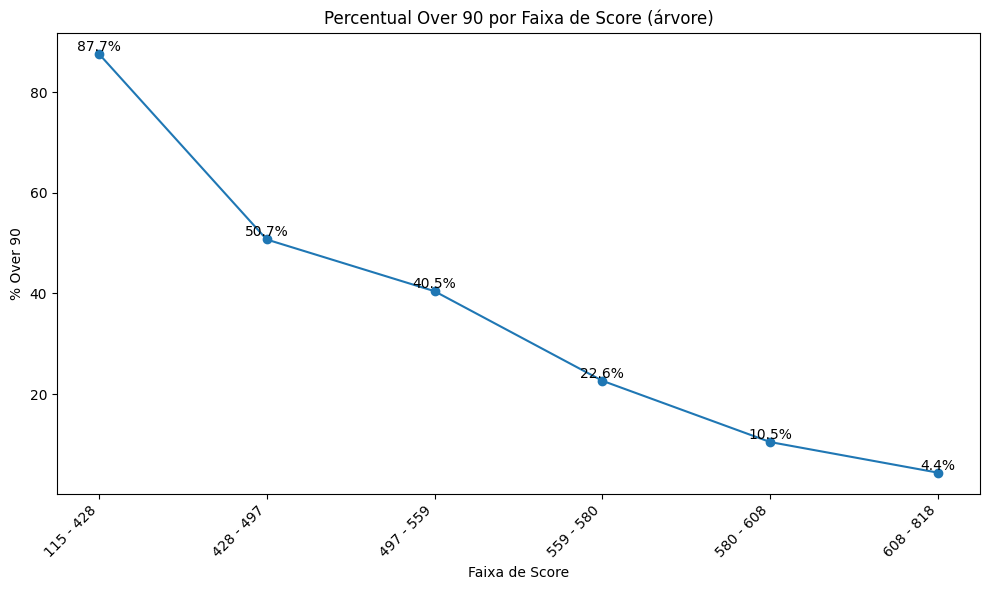

          score_bin  OVER_90_PCT score_min score_max      label
0  (115.999, 428.5]     0.876501   115.999     428.5  115 - 428
1    (428.5, 497.5]     0.507332   428.500     497.5  428 - 497
2    (497.5, 559.5]     0.404536   497.500     559.5  497 - 559
3    (559.5, 580.5]     0.226488   559.500     580.5  559 - 580
4    (580.5, 608.5]     0.104667   580.500     608.5  580 - 608
5    (608.5, 818.0]     0.043804   608.500     818.0  608 - 818


In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier

def binning_por_arvore(df, col_score='SCR',
                       col_saldo='SALDO_CURVA_GLOBAL',
                       col_over='SALDO_OVER_90_GLOBAL',
                       max_leaf_nodes=6, min_samples_leaf=50):
    """
    Usa árvore de decisão para encontrar faixas ótimas de score que
    discriminam inadimplência (Over_90).
    """
    work = df.copy()
    # cria flag de inadimplência (binária)
    work['flag_over90'] = np.where(work[col_over] > 0, 1, 0)
    
    X = work[[col_score]].values
    y = work['flag_over90'].values
    
    tree = DecisionTreeClassifier(
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree.fit(X, y)
    
    # extrair thresholds da árvore
    thresholds = sorted([t for t in tree.tree_.threshold if t != -2])
    # criar lista de bordas (inclui min e max)
    bordas = [work[col_score].min()] + thresholds + [work[col_score].max()]
    
    # categorizar
    work['score_bin'] = pd.cut(work[col_score], bins=bordas, include_lowest=True)
    
    # calcular Over_90% ponderado por saldo em cada faixa
    resumo = (
        work.groupby('score_bin')
        .apply(lambda g: g[col_over].sum() / g[col_saldo].sum() if g[col_saldo].sum() > 0 else np.nan)
        .reset_index(name='OVER_90_PCT')
    )
    resumo['score_min'] = resumo['score_bin'].apply(lambda iv: iv.left)
    resumo['score_max'] = resumo['score_bin'].apply(lambda iv: iv.right)
    resumo['label'] = resumo['score_min'].round(0).astype(int).astype(str) + ' - ' + \
                      resumo['score_max'].round(0).astype(int).astype(str)
    return resumo

def plot_over90_linha(tb):
    plt.figure(figsize=(10,6))
    plt.plot(tb['label'], tb['OVER_90_PCT']*100, marker='o')
    for i, v in enumerate(tb['OVER_90_PCT']*100):
        plt.text(i, v, f"{v:.1f}%", ha='center', va='bottom')
    plt.ylabel('% Over 90')
    plt.xlabel('Faixa de Score')
    plt.title('Percentual Over 90 por Faixa de Score (árvore)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ===== Uso =====
tb = binning_por_arvore(df_novo,
                        col_score='SCR',
                        col_saldo='SALDO_CURVA_GLOBAL',
                        col_over='SALDO_OVER_90_GLOBAL',
                        max_leaf_nodes=6)  # controla nº máximo de faixas
plot_over90_linha(tb)
print(tb)


C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\721187920.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('score_bin')
C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\721187920.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[col_over].sum() / g[col_saldo].sum() if g[col_saldo].sum() > 0 else np.nan)


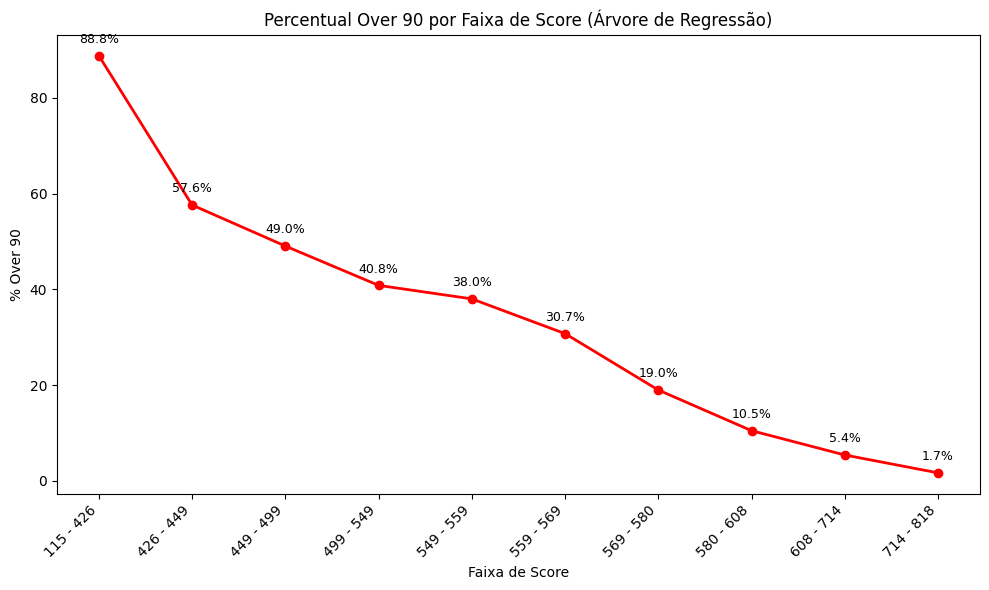

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

def binning_por_arvore_regressao(df, col_score='SCR',
                                 col_saldo='SALDO_CURVA_GLOBAL',
                                 col_over='SALDO_OVER_90_GLOBAL',
                                 max_leaf_nodes=10, min_samples_leaf=50):
    """
    Usa árvore de regressão (DecisionTreeRegressor) para encontrar faixas ótimas
    de score que discriminam a taxa OVER_90% (ponderada por saldo).
    """
    work = df.copy()

    # calcula taxa individual ponderada (cliente a cliente)
    work['OVER_RATIO'] = np.where(
        work[col_saldo] > 0, work[col_over] / work[col_saldo], 0
    )

    X = work[[col_score]].values
    y = work['OVER_RATIO'].values

    tree = DecisionTreeRegressor(
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree.fit(X, y)

    # thresholds usados na árvore
    thresholds = sorted([t for t in tree.tree_.threshold if t != -2])
    bordas = [work[col_score].min()] + thresholds + [work[col_score].max()]

    # categorizar
    work['score_bin'] = pd.cut(work[col_score], bins=bordas, include_lowest=True)

    # calcular taxa ponderada por saldo em cada faixa
    resumo = (
        work.groupby('score_bin')
        .apply(lambda g: g[col_over].sum() / g[col_saldo].sum() if g[col_saldo].sum() > 0 else np.nan)
        .reset_index(name='OVER_90_PCT')
    )
    resumo['score_min'] = resumo['score_bin'].apply(lambda iv: iv.left)
    resumo['score_max'] = resumo['score_bin'].apply(lambda iv: iv.right)
    resumo['label'] = resumo['score_min'].round(0).astype(int).astype(str) + ' - ' + \
                      resumo['score_max'].round(0).astype(int).astype(str)

    return resumo

def plot_over90_linha(tb):
    plt.figure(figsize=(10,6))
    plt.plot(tb['label'], tb['OVER_90_PCT']*100, marker='o', color='red', linewidth=2)

    # rótulos acima dos pontos, com deslocamento de 2%
    for i, v in enumerate(tb['OVER_90_PCT']*100):
        plt.text(i, v + 2, f"{v:.1f}%", ha='center', va='bottom', fontsize=9, color='black')

    plt.ylabel('% Over 90')
    plt.xlabel('Faixa de Score')
    plt.title('Percentual Over 90 por Faixa de Score (Árvore de Regressão)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# ===== Exemplo de uso =====
tb = binning_por_arvore_regressao(df_novo,
                                  col_score='SCR',
                                  col_saldo='SALDO_CURVA_GLOBAL',
                                  col_over='SALDO_OVER_90_GLOBAL',
                                  max_leaf_nodes=10)
plot_over90_linha(tb)
#print(tb)


In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor

def binning_por_arvore_regressao(df, col_score='SCR',
                                 col_saldo='SALDO_CURVA_GLOBAL',
                                 col_over='SALDO_OVER_90_GLOBAL',
                                 max_leaf_nodes=10, min_samples_leaf=50):
    """
    Usa árvore de regressão (DecisionTreeRegressor) para encontrar faixas ótimas
    de score que discriminam a taxa OVER_90% (ponderada por saldo).
    Retorna colunas: score_bin, OVER_90_PCT, OVER_SUM, SALDO_SUM, score_min, score_max, label
    """
    work = df.copy()

    # taxa individual (só para treinar a árvore)
    work['OVER_RATIO'] = np.where(work[col_saldo] > 0, work[col_over] / work[col_saldo], 0.0)

    X = work[[col_score]].values
    y = work['OVER_RATIO'].values

    tree = DecisionTreeRegressor(
        max_leaf_nodes=max_leaf_nodes,
        min_samples_leaf=min_samples_leaf,
        random_state=42
    )
    tree.fit(X, y)

    # thresholds e bordas
    thresholds = sorted([t for t in tree.tree_.threshold if t != -2])
    bordas = [work[col_score].min()] + thresholds + [work[col_score].max()]

    # categorizar por faixas contínuas
    work['score_bin'] = pd.cut(work[col_score], bins=bordas, include_lowest=True)

    # agregação ponderada por saldo
    resumo = (
        work.groupby('score_bin')
        .agg(OVER_SUM=(col_over, 'sum'),
             SALDO_SUM=(col_saldo, 'sum'))
        .reset_index()
    )
    resumo['OVER_90_PCT'] = np.where(resumo['SALDO_SUM'] > 0, resumo['OVER_SUM'] / resumo['SALDO_SUM'], np.nan)

    # metadados das faixas
    resumo['score_min'] = resumo['score_bin'].apply(lambda iv: float(iv.left))
    resumo['score_max'] = resumo['score_bin'].apply(lambda iv: float(iv.right))
    resumo['label'] = resumo['score_min'].round(0).astype(int).astype(str) + ' - ' + \
                      resumo['score_max'].round(0).astype(int).astype(str)

    # ordenar pela borda inferior
    resumo = resumo.sort_values('score_min').reset_index(drop=True)
    return resumo

def plot_over90_com_saldo(tb):
    """
    Gráfico combinado:
      - Barras (saldo da carteira, em milhões)
      - Linha vermelha: % Over 90, com rótulos deslocados
    """
    fig, ax1 = plt.subplots(figsize=(12,6))

    labels = tb['label']
    saldo_milhoes = tb['SALDO_SUM'] / 1e6
    over_pct = tb['OVER_90_PCT'] * 100

    # barras do saldo
    bars = ax1.bar(labels, saldo_milhoes, alpha=0.7, label='Saldo (R$ mi)')
    ax1.set_ylabel('Saldo da Carteira (R$ milhões)')
    # rótulos nas barras (em milhões, 1 casa)
    for bar in bars:
        h = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2, h + max(saldo_milhoes)*0.02, f"{h:.1f}",
                 ha='center', va='bottom', fontsize=9)

    # linha do % Over 90 (vermelha)
    ax2 = ax1.twinx()
    ax2.plot(labels, over_pct, marker='o', color='red', linewidth=2, label='% Over 90')
    ax2.set_ylabel('% Over 90', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # rótulos nos pontos da linha (deslocamento para não encostar)
    for i, v in enumerate(over_pct):
        ax2.text(i, v + max(over_pct)*0.03, f"{v:.1f}%", ha='center', va='bottom',
                 fontsize=9, color='red')

    plt.title('Distribuição da Carteira (R$ mi) e % Over 90 por Faixa de Score')
    plt.xticks(rotation=45, ha='right')
    fig.tight_layout()
    plt.show()

# Carteira Global

In [34]:
bins = tb[['score_min', 'score_max']].to_numpy().flatten()
bins = sorted(set(bins))  # remove duplicados e ordena

# Expandir os extremos
bins[0] = -np.inf
bins[-1] = np.inf

# Salvar em formato binário (.npy)
np.save("bins_PD90.npy", np.array(bins))

In [35]:
tb

,score_bin,OVER_90_PCT,score_min,score_max,label
0,"(115.999, 426.5]",0.888232,115.999,426.5,115 - 426
1,"(426.5, 449.5]",0.576194,426.500,449.5,426 - 449
2,"(449.5, 499.5]",0.490485,449.500,499.5,449 - 499
3,"(499.5, 549.5]",0.408328,499.500,549.5,499 - 549
4,"(549.5, 559.5]",0.380104,549.500,559.5,549 - 559
5,"(559.5, 569.5]",0.307457,559.500,569.5,559 - 569
6,"(569.5, 580.5]",0.189637,569.500,580.5,569 - 580
7,"(580.5, 608.5]",0.104667,580.500,608.5,580 - 608
8,"(608.5, 714.5]",0.053866,608.500,714.5,608 - 714
9,"(714.5, 818.0]",0.016549,714.500,818.0,714 - 818


C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\3087362489.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('score_bin')


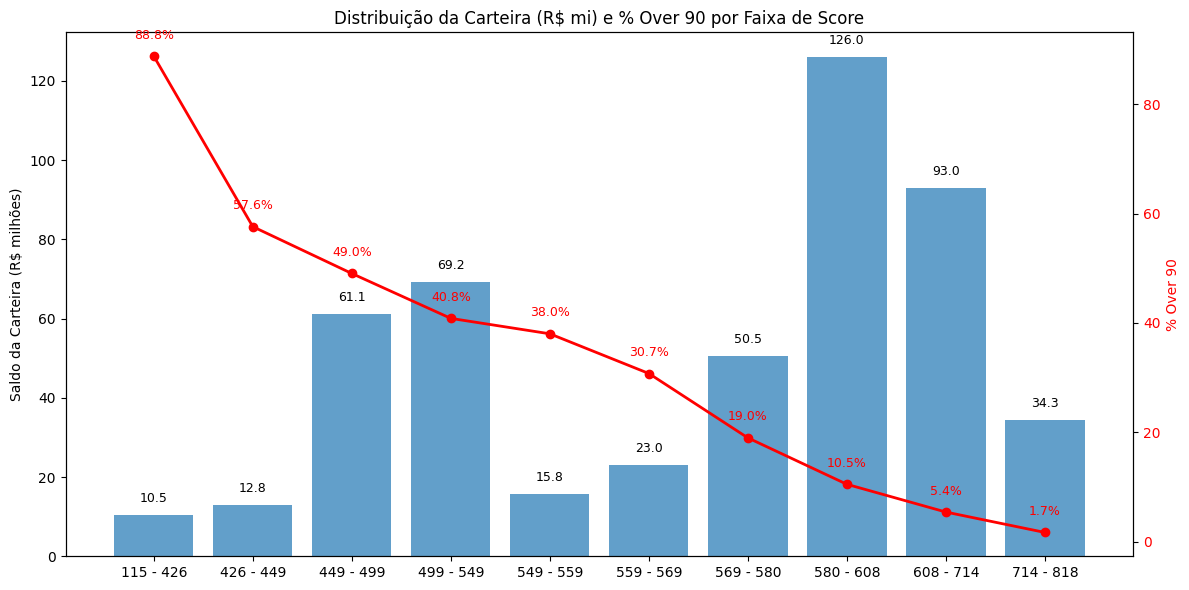

In [36]:
# ===== Exemplo de uso =====
tb = binning_por_arvore_regressao(df_novo,
                                  col_score='SCR',
                                  col_saldo='SALDO_CURVA_GLOBAL',
                                  col_over='SALDO_OVER_90_GLOBAL',
                                  max_leaf_nodes=10)
plot_over90_com_saldo(tb)

# Empréstimo

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\3087362489.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('score_bin')


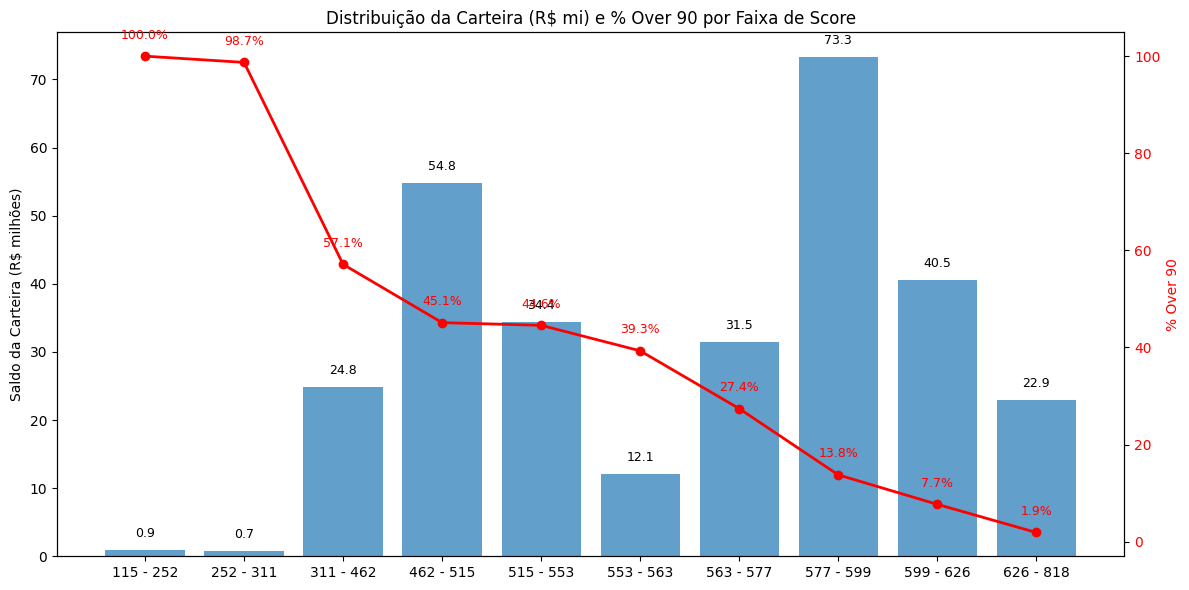

In [37]:
# ===== Exemplo de uso =====
tb = binning_por_arvore_regressao(df_novo,
                                  col_score='SCR',
                                  col_saldo='SALDO_CURVA_EMP',
                                  col_over='SALDO_OVER_90_EMP',
                                  max_leaf_nodes=10)
plot_over90_com_saldo(tb)



# Crediário

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\3087362489.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('score_bin')


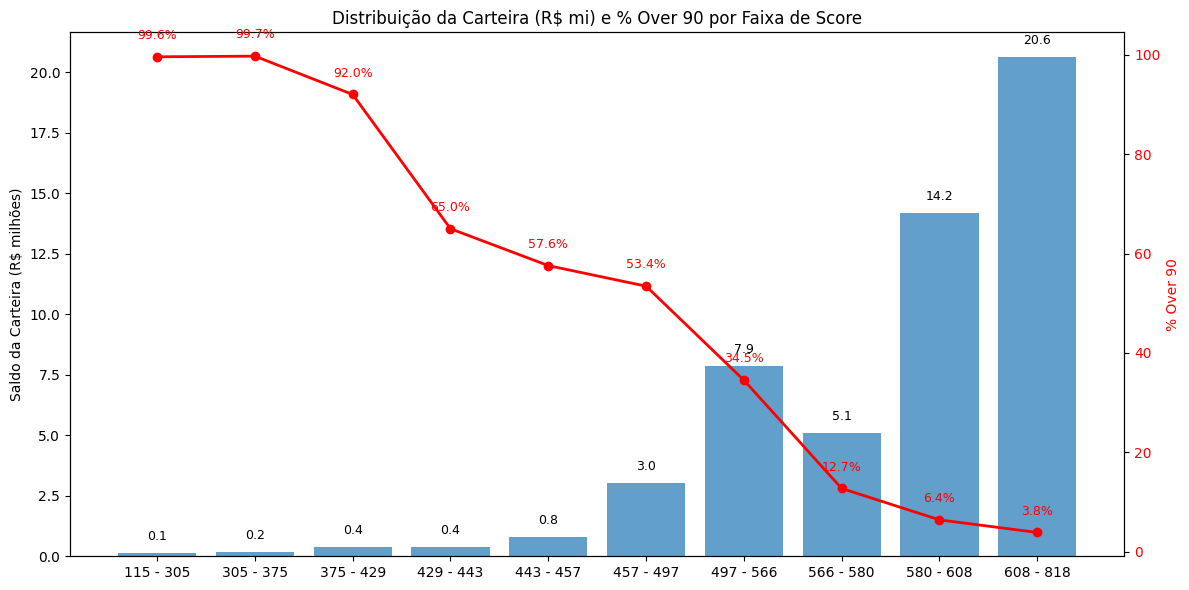

In [38]:
# ===== Exemplo de uso =====
tb = binning_por_arvore_regressao(df_novo,
                                  col_score='SCR',
                                  col_saldo='SALDO_CURVA_CRE',
                                  col_over='SALDO_OVER_90_CRE',
                                  max_leaf_nodes=10)
plot_over90_com_saldo(tb)


# Financiamento

C:\Users\fernando.monteiro\AppData\Local\Temp\ipykernel_10796\3087362489.py:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  work.groupby('score_bin')


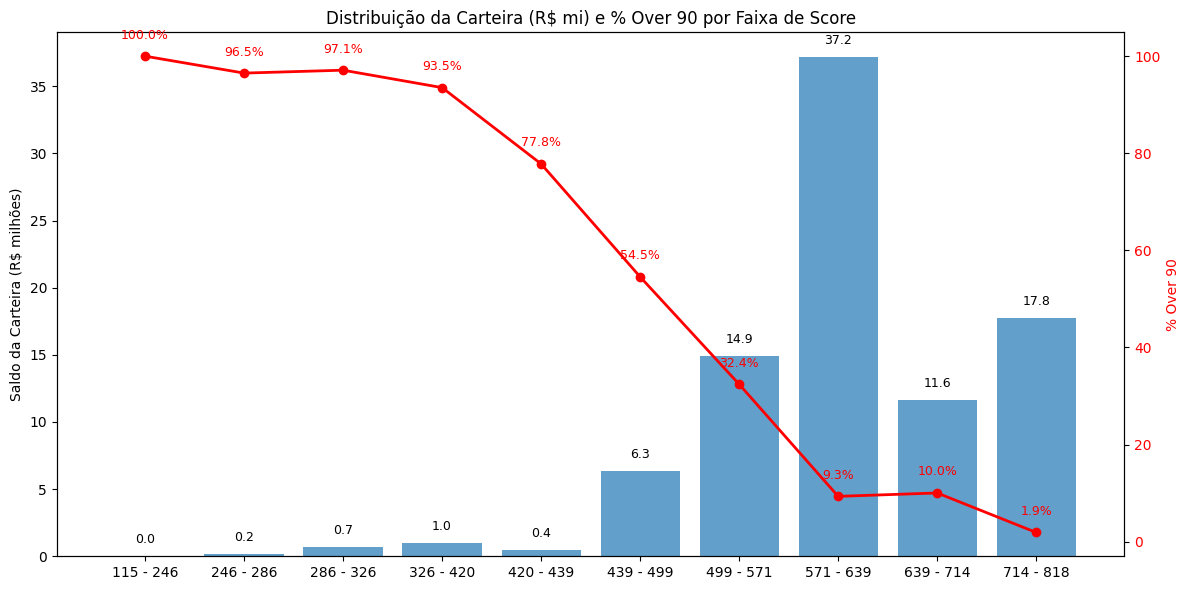

In [39]:
# ===== Exemplo de uso =====
tb = binning_por_arvore_regressao(df_novo,
                                  col_score='SCR',
                                  col_saldo='SALDO_CURVA_FIN',
                                  col_over='SALDO_OVER_90_FIN',
                                  max_leaf_nodes=10)
plot_over90_com_saldo(tb)
